In [157]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [158]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]

data = pd.read_csv("D:/HAR/WISDM/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
    
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()

<ipython-input-158-7ee769a67789>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


<Axes: xlabel='activity', ylabel='count'>

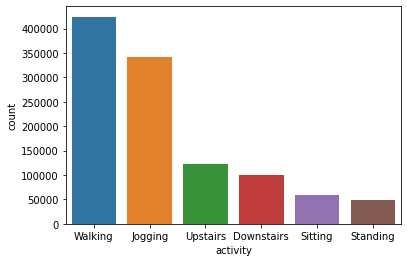

In [159]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

In [160]:
df['activity'].value_counts()

activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64

<Axes: xlabel='activity', ylabel='count'>

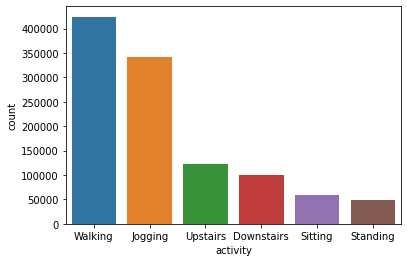

In [161]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

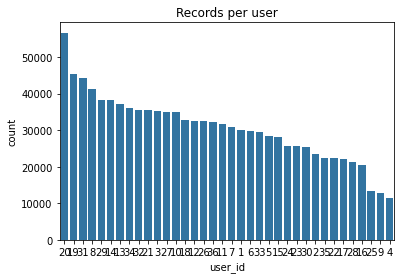

In [162]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


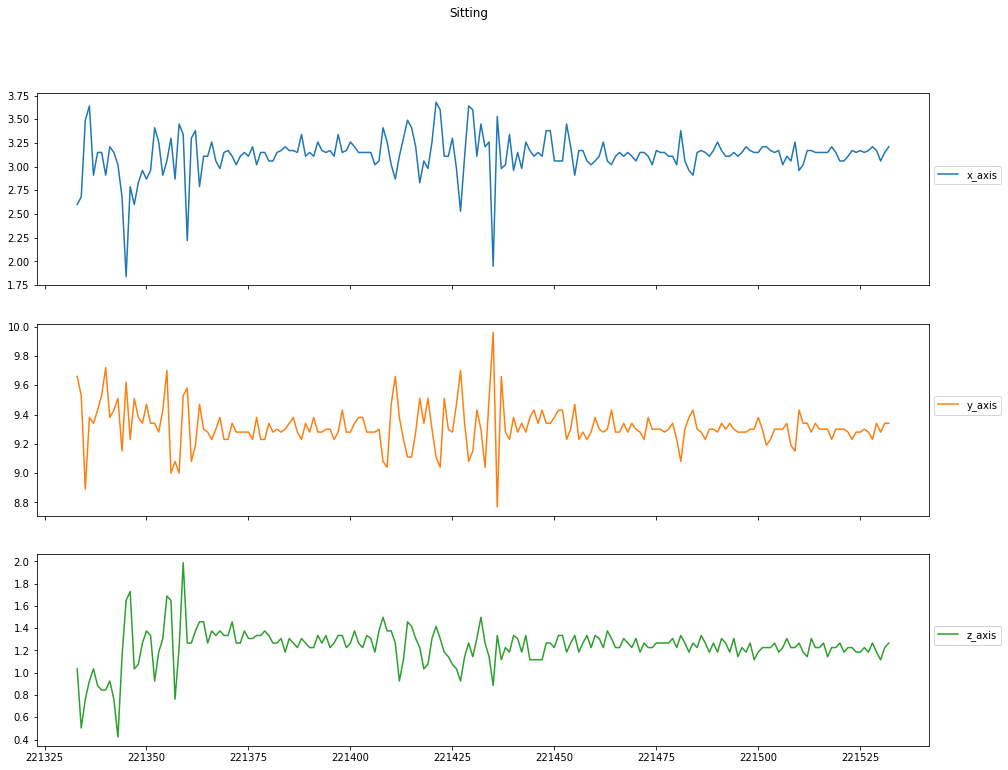

In [163]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))
        
plot_activity("Sitting", df)

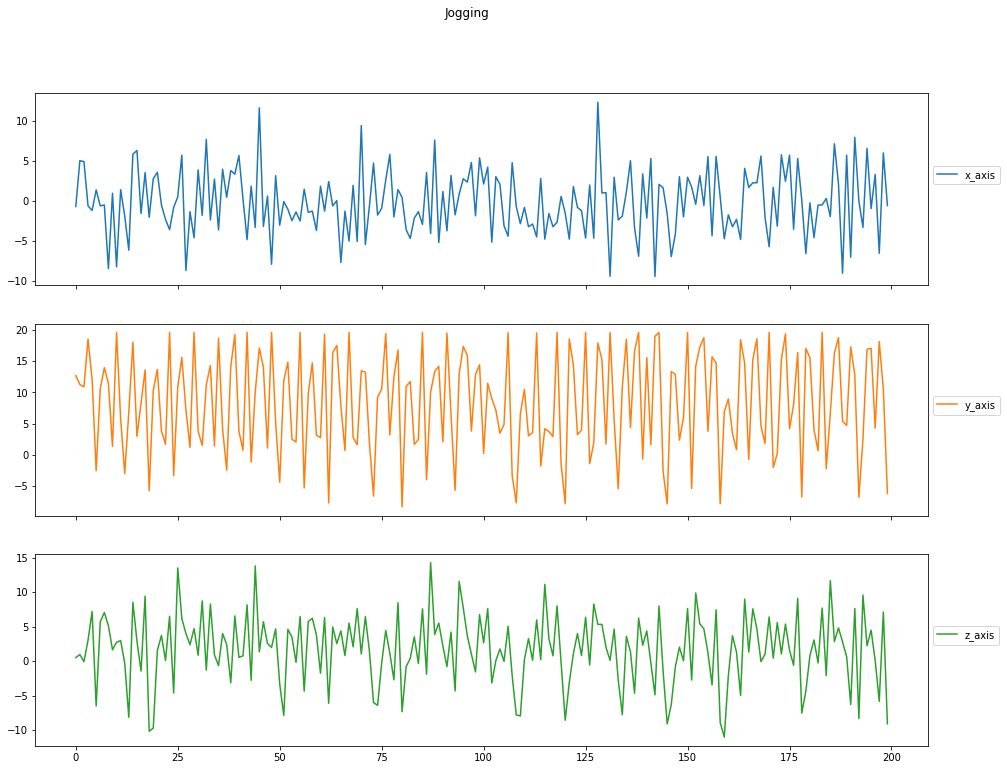

In [164]:
plot_activity("Jogging", df)

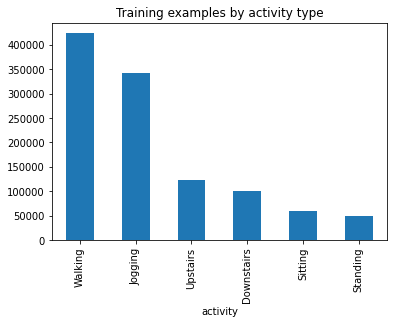

In [165]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [166]:
'''
indexes = df[(df['activity'] == 'Walking') | (df['activity'] == 'Jogging') | 
             (df['activity'] == 'Upstairs') | (df['activity'] == 'Downstairs')].index
df.drop(indexes , inplace=True)
'''

"\nindexes = df[(df['activity'] == 'Walking') | (df['activity'] == 'Jogging') | \n             (df['activity'] == 'Upstairs') | (df['activity'] == 'Downstairs')].index\ndf.drop(indexes , inplace=True)\n"

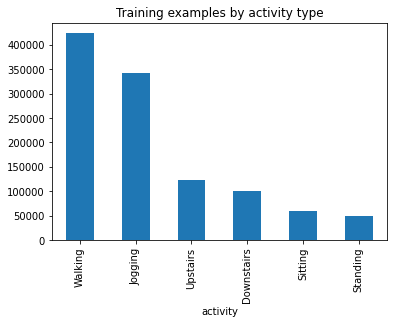

In [167]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [168]:
#Splitting and scaling the data

df_train = df[df["user_id"] <= 30]
df_test = df[df["user_id"] > 30]

In [169]:
df_train

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [170]:
df_train['activity'].value_counts()

activity
Walking       353508
Jogging       275439
Upstairs      102810
Downstairs     82634
Sitting        45810
Standing       38159
Name: count, dtype: int64

In [171]:
df_test['activity'].value_counts()

activity
Walking       70889
Jogging       66737
Upstairs      20059
Downstairs    17793
Sitting       14129
Standing      10236
Name: count, dtype: int64

# Balance Adjustment

In [172]:
Sitting = df_train[df_train['activity']=='Sitting'].head(38159).copy()
Standing  = df_train[df_train['activity']=='Standing'].head(38159).copy()

In [173]:
TSitting = df_test[df_test['activity']=='Sitting'].head(10236).copy()
TStanding  = df_test[df_test['activity']=='Standing'].head(10236).copy()

In [174]:
new_df_train = pd.DataFrame()
new_df_train = pd.concat([new_df_train, Sitting, Standing])
new_df_train.shape

(76318, 6)

In [175]:
new_df_test = pd.DataFrame()
new_df_test = pd.concat([new_df_test, TSitting, TStanding])
new_df_test.shape

(20472, 6)

In [176]:
new_df_train['activity'].value_counts()

activity
Sitting     38159
Standing    38159
Name: count, dtype: int64

In [177]:
new_df_test['activity'].value_counts()

activity
Sitting     10236
Standing    10236
Name: count, dtype: int64

In [178]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

new_df_train.loc[:, scale_columns] = scaler.transform(new_df_train[scale_columns].to_numpy())
new_df_test.loc[:, scale_columns] = scaler.transform(new_df_test[scale_columns].to_numpy())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [179]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(df_train[["x_axis", "y_axis", "z_axis"]], df_train.activity, TIME_STEPS,
                                  STEP)
X_test, y_test = create_dataset(df_test[["x_axis", "y_axis", "z_axis"]], df_test.activity, TIME_STEPS, STEP)

print(X_train.shape, y_train.shape)

<ipython-input-179-a8ce5bd15308>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-179-a8ce5bd15308>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-179-a8ce5bd15308>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.1

(22454, 200, 3) (22454, 1)


In [180]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 6)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [181]:
#Epoch 500

verbose,epochs,batch_size=1,10,32 

n_timesteps,n_features,n_outputs=X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [182]:
#CNN MODEL

inputs=keras.Input(shape=(n_timesteps,n_features))


conv_1=tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=2,activation='relu')(inputs)
maxpool_1=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(conv_1)

conv_2=tf.keras.layers.Conv1D(filters=96,kernel_size=3,strides=1,activation='relu')(maxpool_1)
maxpool_2=tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(conv_2)

conv_3=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu')(maxpool_2)
avg_pooling=tf.keras.layers.GlobalAveragePooling1D()(conv_3)
batch_norm=tf.keras.layers.BatchNormalization()(avg_pooling)

output=tf.keras.layers.Dense(n_outputs,activation='softmax')(batch_norm)
model=tf.keras.Model(inputs=inputs,outputs=output)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 3)]          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 98, 64)            1024      
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 49, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_26 (Conv1D)          (None, 47, 96)            18528     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 46, 96)            0         
 ng1D)                                                           
                                                                 
 conv1d_27 (Conv1D)          (None, 44, 32)            9248

In [183]:
import pydot
from tensorflow.keras.utils import plot_model 

plot_model(model, show_shapes=True, to_file='CNN_Model.png')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [184]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size)
model.summary()

Epoch 1/10
702/702 [==============================] - 7s 9ms/step - loss: 0.2712 - accuracy: 0.9161
Epoch 2/10
702/702 [==============================] - 6s 9ms/step - loss: 0.0933 - accuracy: 0.9707
Epoch 3/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0643 - accuracy: 0.9780
Epoch 4/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0499 - accuracy: 0.9836
Epoch 5/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0432 - accuracy: 0.9857
Epoch 6/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0398 - accuracy: 0.9866
Epoch 7/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0357 - accuracy: 0.9884
Epoch 8/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0345 - accuracy: 0.9882
Epoch 9/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0297 - accuracy: 0.9902
Epoch 10/10
702/702 [==============================] - 7s 10ms/step - loss: 0.0312 - accuracy

In [186]:
loss = history.history["loss"]
acc = history.history["accuracy"]

In [185]:
%time
print(X_test.shape,y_test.shape)
base_loss,base_accuracy=model.evaluate(X_test,y_test,batch_size=batch_size,verbose=1)

score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

Wall time: 0 ns
(4992, 200, 3) (4992, 6)
156/156 [==============================] - 1s 4ms/step - loss: 0.2722 - accuracy: 0.9347
Accuracy >93.469554
Base Loss >0.27


In [187]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

156/156 [==============================] - 1s 4ms/step


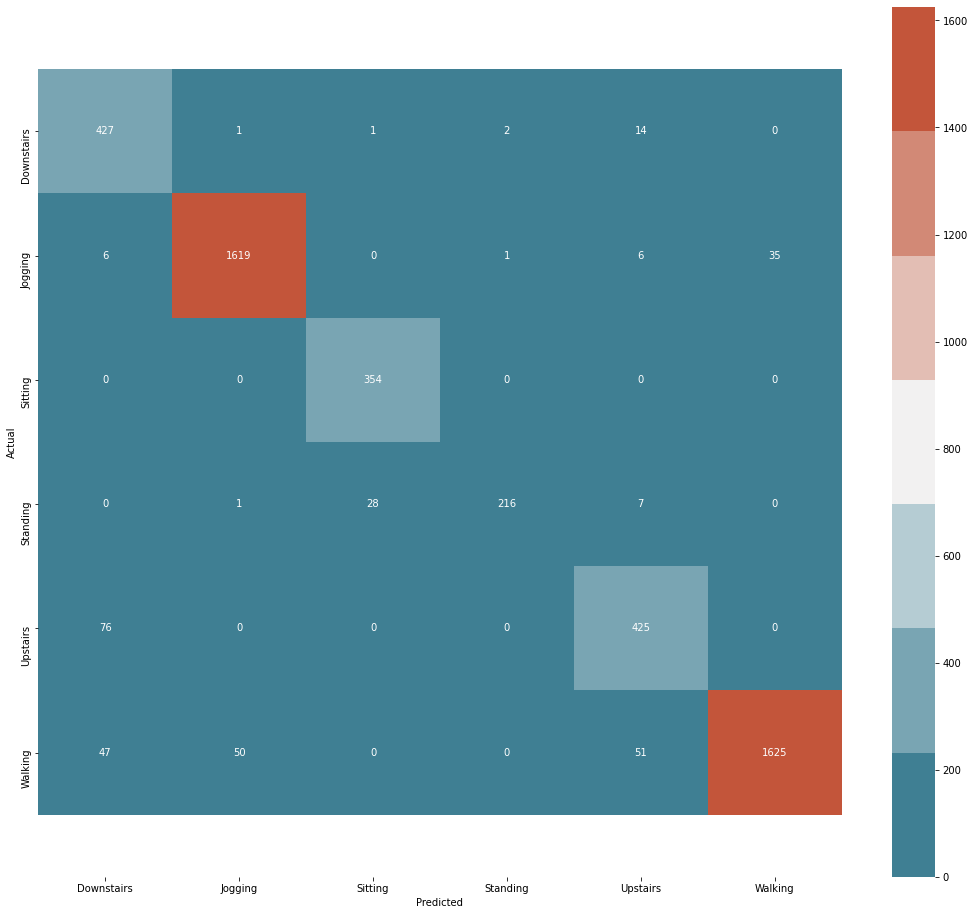

In [188]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(18, 16)) 
    ax = sns.heatmap(cm, annot = True, fmt = "d", cmap = sns.diverging_palette(220, 20, n = 7), ax = ax)

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
plot_cm(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), enc.categories_[0])